# Nutrient analysis of global fisheries

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import theano.tensor as tt
from pymc3.backends import SQLite
import seaborn as sns
import scipy as sp
import pdb

In [2]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Helper functions
def indexall_B(L,B):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    a, b = poo.index(B), 0
    poo[b], poo[a] = poo[a], poo[b]
    
    Ix[Ix==b] = -1
    Ix[Ix==a] = 0
    Ix[Ix==-1] = a
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Coefficient of variation
cv =  lambda x: np.var(x) / np.mean(x)

## Import data

In [3]:
# Nutritional data
ndata = pd.read_excel('Nutrient_data.xlsx')
# Traits data
tdata = pd.read_excel('Traits_all.xlsx')

In [4]:
tdata.columns.values

array(['order', 'species_traits_all', 'level', 'Class', 'Order', 'Family',
       'Genus_1', 'Species_Species', 'DemersPelag', 'EnvTemp',
       'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm', 'DemersPelagLevel', 'EnvTempLevel',
       'DepthRangeDeepLevel', 'trophic_levelLevel', 'Feeding_pathLevel',
       'LMaxLevel', 'BodyShapeILevel', 'KLevel', 'tmLevel'], dtype=object)

In [5]:
# Add traits information to nutritional dataframe
indx = match(ndata.Species_from_search.unique(),list(tdata.species_traits_all.values))
rindx = match(ndata.Species_from_search,list(ndata.Species_from_search.unique()))

# Traits to port over
tmp = ['Class', 'Order', 'Family','Genus_1', 'DemersPelag',
       'EnvTemp', 'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm']
# Port over
for trait in tmp:
    ndata[trait] = tdata[trait].values[indx][rindx]

ndata.head()

,ID_no,Species_from_search,Protein_Replicates,Protein_Value_perc,Protein_Variance,Zn_Replicates,Zn_Value,Zn_Variance,Ca_Replicates,Ca_Value,...,Genus_1,DemersPelag,EnvTemp,DepthRangeDeep,trophic_level,Feeding_path,LMax,BodyShapeI,K,tm
0,A_3,Merluccius_merluccius,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Merluccius,demersal,temperate,1075.0,4.40,pelagic,140.0,elongate,0.148,4.199469
1,A_4,Scomber_scombrus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.262,2.636997
2,A_38,Scomber_scombrus,NaN,NaN,NaN,11,0.8090,NaN,NaN,NaN,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.262,2.636997
3,A_39,Merluccius_gayi_gayi,NaN,NaN,NaN,11,0.1787,NaN,NaN,NaN,...,Merluccius,pelagic_oceanic,polar_deep,500.0,4.26,pelagic,87.0,fusiform,0.120,5.100000
4,A_40,Engraulis_encrasicolus,NaN,NaN,NaN,11,0.7041,NaN,NaN,NaN,...,Engraulis,pelagic_neritic,subtropical,400.0,3.12,pelagic,20.0,elongate,1.000,1.000000


In [6]:
ndata.columns.values

array(['ID_no', 'Species_from_search', 'Protein_Replicates',
       'Protein_Value_perc', 'Protein_Variance', 'Zn_Replicates',
       'Zn_Value', 'Zn_Variance', 'Ca_Replicates', 'Ca_Value',
       'Ca_Variance', 'Fe_Replicates', 'Fe_Value', 'Fe_Variance',
       'Se_Replicates', 'Se_Value', 'Se_Variance', 'P_Replicates',
       'P_Value', 'P_Variance', 'Mg_Replicates', 'Mg_Value',
       'Mg_Variance', 'VitA_Replicates', 'VitA_Value', 'VitA_Variance',
       'VitB12_Replicates', 'VitB12_Value', 'VitB12_Variance',
       'O3_Replicates', 'O3_Value', 'O3_Variance', 'Unnamed: 32',
       'Form_Clean', 'Search', 'Year', 'GeographicLocation_Cleaned',
       'Family', 'Prep', 'Protein_prep', 'Minerals_prep', 'Vitamin_prep',
       'FA_prep', 'Protein_Sample_Weight', 'Zn_Sample_Weight',
       'Ca_Sample_Weight', 'Fe_Sample_Weight', 'Se_Sample_Weight',
       'P_Sample_Weight', 'Mg_Sample_Weight', 'VitA_Sample_Weight',
       'VitB12_Sample_Weight', 'O3_Sample_Weight', 'Class', 'Order',
     

### Datasets

In [7]:
Nutrients = ['Protein', 'Zinc', 'Iron', 'Calcium', 'Omega-3', 'Vitamin_A', 'Selenium']
Nkeys = ['Protein_Value_perc', 'Zn_Value', 'Fe_Value', 'Ca_Value', 'O3_Value', 'VitA_Value', 'Se_Value']
nnutrients = len(Nutrients)

In [8]:
# Sample sizes for each nutrient
[sum(np.isnan(ndata[n].values)==False) for n in Nkeys]

[627, 196, 173, 170, 176, 69, 134]

## ======= Change nutrient here & likelihood in the model ========= #

In [9]:
i = 6
nut = Nutrients[i]
nut

'Selenium'

In [10]:
# Response
var = Nkeys[i]
Y_ = ndata[var].values
# Filter
indx = np.isnan(Y_)==False
Y = np.log(Y_[indx]+1)
Y_ = Y_[indx]
# Filter dataframe
tmpdata = ndata[indx]

# Index for orders
Order,Io = indexall(tmpdata.Order.values)
nord = len(Order)

# Covariates
Habitat,Ih = indexall_B(tmpdata['DemersPelag'].values, 'demersal')
nhabs = len(Habitat)
Climate,Ic = indexall_B(tmpdata['EnvTemp'].values, 'temperate')
nclim = len(Climate)
MaxDepth = np.log(tmpdata['DepthRangeDeep'].values)
TL = tmpdata['trophic_level'].values
Pelagic = tmpdata['Feeding_path'].values=="pelagic"
LMax = np.log(tmpdata['LMax'].values)
Body,Ib = indexall_B(tmpdata['BodyShapeI'].values, 'fusiform')
nbod = len(Body)
K = tmpdata['K'].values
tm = np.log(tmpdata['tm'].values)

# Nussiance parameters
Form,If = indexall_B(tmpdata['Form_Clean'].values, 'muscle')
nform = len(Form)
Prep,Ip = indexall_B(tmpdata['Prep'].values, 'wet')
nprep = len(Prep)
Search,Is = indexall_B(tmpdata['Search'].values, 'WOS')
nsearch = len(Search)

In [11]:
Habitat

['demersal',
 'pelagic_neritic',
 'pelagic_oceanic',
 'benthopelagic',
 'reef_associated']

## Specify Bayesian model

In [12]:
Model_1 = pm.Model()

with Model_1:
    # Intercept
    γ0 = pm.Normal('Intercept', mu=0, tau=0.0001)
    # Observation model
    σγ = pm.Uniform('Sigma_γ', lower=0, upper=1000)
    β0 = pm.Normal('Order', mu=γ0, sd=σγ, shape=nord)
    
    
    #"""
    # Habitat type
    β1_ = pm.Normal('Habitat', 0, tau=0.01, shape=nhabs-1)
    β1 = tt.set_subtensor(tt.zeros(shape=nhabs)[1:], β1_)
    # Climate
    β2_ = pm.Normal('Climate', 0, tau=0.01, shape=nclim-1)
    β2 = tt.set_subtensor(tt.zeros(shape=nclim)[1:], β2_)
    # Maximum Depth
    β3 = pm.Normal('MaxDepth', 0, tau=0.01)
    # Total Length
    β4 = pm.Normal('TL', 0, tau=0.01)
    # Pelagic/demersal
    β5 = pm.Normal('pelagic', 0, tau=0.01)
    # Maximum length
    β6 = pm.Normal('LMax', 0, tau=0.01)
    # Body form
    β7_ = pm.Normal('Body', 0, tau=0.01, shape=nbod-1)
    β7 = tt.set_subtensor(tt.zeros(shape=nbod)[1:], β7_)
    # Growth parameter
    β8 = pm.Normal('K', 0, tau=0.01)
    # Age at maturity
    β9 = pm.Normal('tm', 0, tau=0.01)
    
    # Form of sample
    β10_ = pm.Normal('Form', 0, tau=0.01, shape=nform-1)
    β10 = tt.set_subtensor(tt.zeros(shape=nform)[1:], β10_)
    # Form of prepartion
    β11_ = pm.Normal('Prep', 0, tau=0.01, shape=nprep-1)
    β11 = tt.set_subtensor(tt.zeros(shape=nprep)[1:], β11_)
    # Database used
    β12_ = pm.Normal('Search', 0, tau=0.01, shape=nsearch-1)
    β12 = tt.set_subtensor(tt.zeros(shape=nsearch)[1:], β12_)
    
    #"""
    
    # Mean model
    μ_ = β0[Io]+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    
    # Normal - Calcium (3), Omega-3 (4), Vitamin-A (5), Selenium (6)
    μ = μ_
    σ = pm.Uniform('Sigma', lower=0, upper=1000)
    Yi = pm.Normal('Yi', mu=μ, sd=σ, observed=Y)
    
    # ST - Protein (0)
    #μ = μ_
    #ν = pm.Uniform('nu', lower=0, upper=4)
    #σ = pm.Uniform('Sigma', lower=0, upper=1000)
    #Yi = pm.StudentT('Yi', nu=ν, mu=μ, sd=σ, observed=Y)
    
    # Gamma model - Zinc (1), Iron (2)
    #μ = tt.exp(μ_)
    #α = pm.Uniform('α', lower=0., upper=100.)
    #Yi = pm.Gamma('Yi', alpha=α, beta=α/μ, observed=Y)
    

INFO (theano.gof.compilelock): Waiting for existing lock by process '6088' (I am process '6121')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/aaronmacneil/.theano/compiledir_Darwin-18.6.0-x86_64-i386-64bit-i386-3.7.1-64/lock_dir


In [13]:
# Sampling
with Model_1:
    # Draw samples
    trace = pm.sample(5000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, Search, Prep, Form, tm, K, Body, LMax, pelagic, TL, MaxDepth, Climate, Habitat, Order, Sigma_γ, Intercept]
Sampling 4 chains: 100%|██████████| 22000/22000 [02:55<00:00, 44.80draws/s] 
There were 385 divergences after tuning. Increase `target_accept` or reparameterize.
There were 289 divergences after tuning. Increase `target_accept` or reparameterize.
There were 265 divergences after tuning. Increase `target_accept` or reparameterize.
There were 476 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


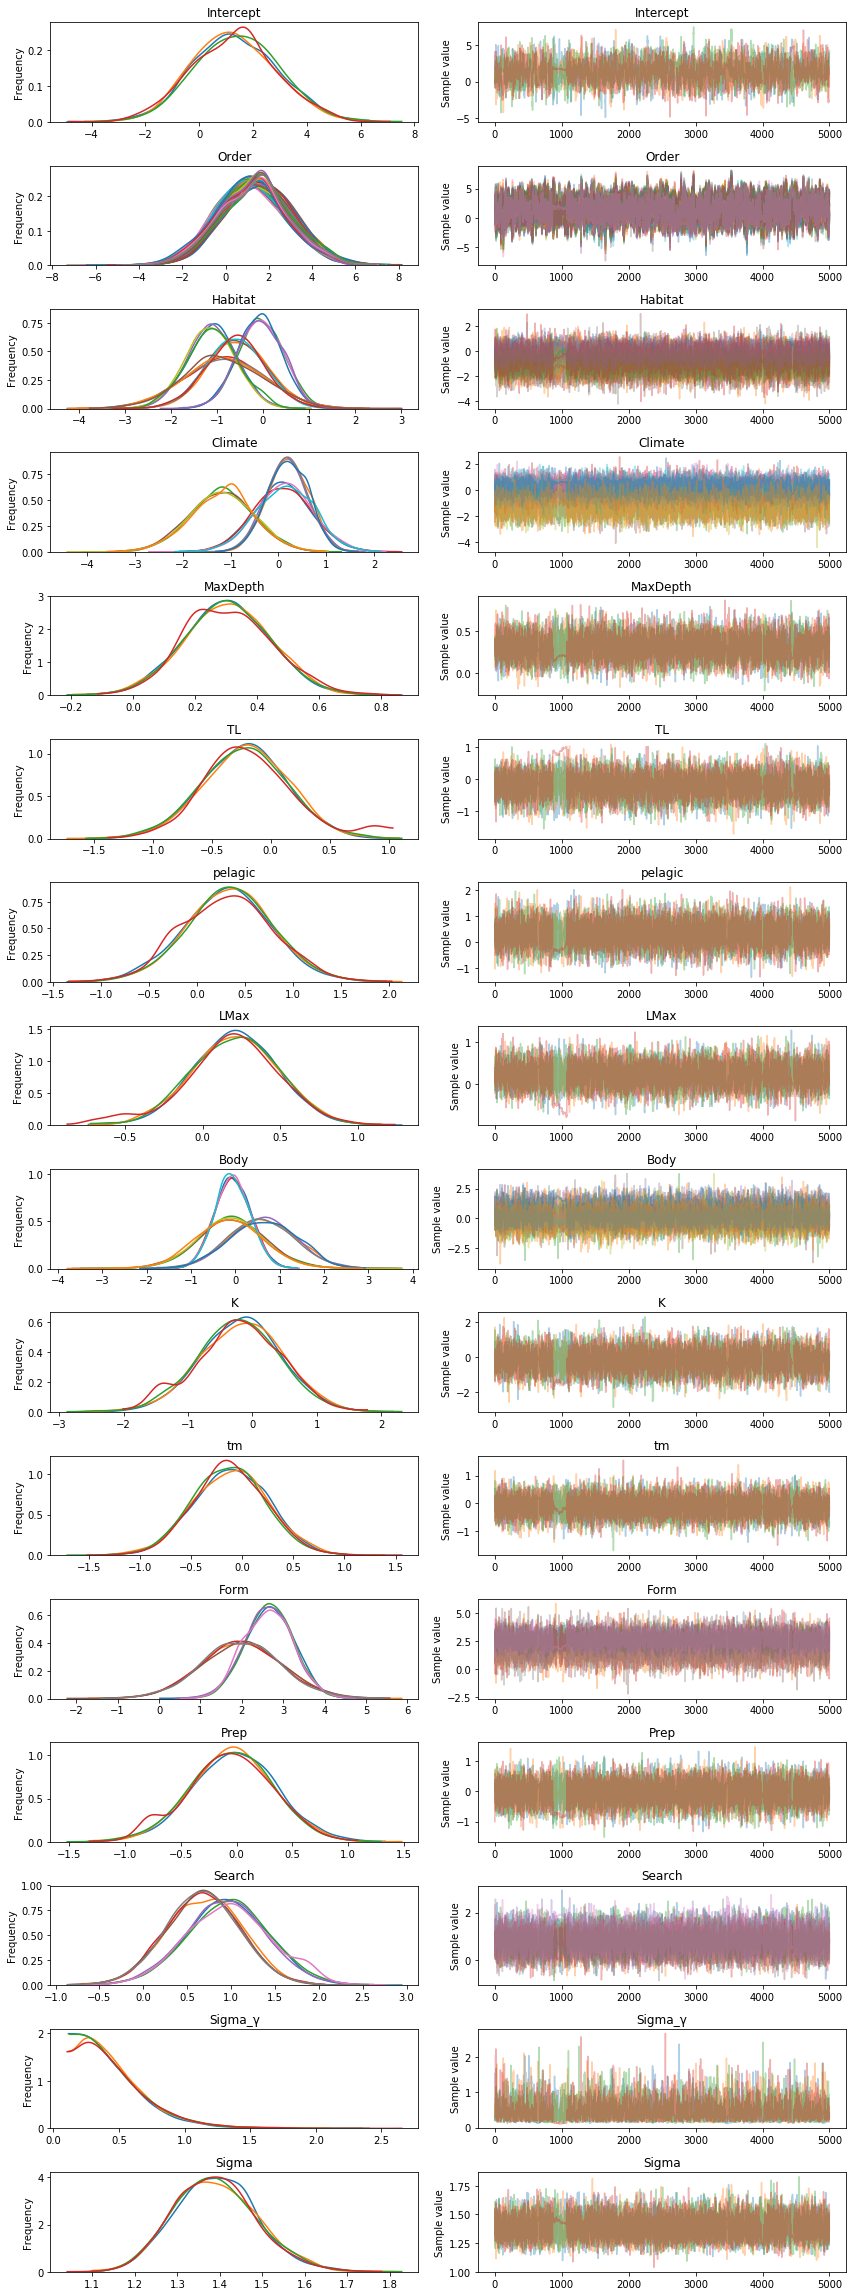

In [14]:
pm.traceplot(trace)
plt.savefig('Figure_S2_'+nut+'.jpg',dpi=300);

In [15]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,1.338821,1.559560,0.036864,-1.661139,4.389010,2042.014480,1.001176
Order__0,1.147958,1.596331,0.037715,-2.034785,4.196900,2089.658990,1.001125
Order__1,1.596306,1.624510,0.037395,-1.522841,4.755955,2102.606922,1.001113
Order__2,1.299360,1.525579,0.035422,-1.726633,4.222551,2096.826446,1.001195
Order__3,1.265925,1.649409,0.037842,-1.961713,4.499240,2172.409300,1.001099
Order__4,1.128210,1.648160,0.038443,-2.157819,4.243834,2140.208902,1.001195
Order__5,1.259106,1.610723,0.037424,-1.897982,4.396530,2161.883082,1.001130
Order__6,1.585446,1.631510,0.036783,-1.536638,4.793955,2178.621444,1.001046
Order__7,1.234249,1.598863,0.037343,-1.962871,4.266377,2120.864681,1.001157
Order__8,1.337394,1.510834,0.035552,-1.566282,4.326674,2080.170255,1.001051


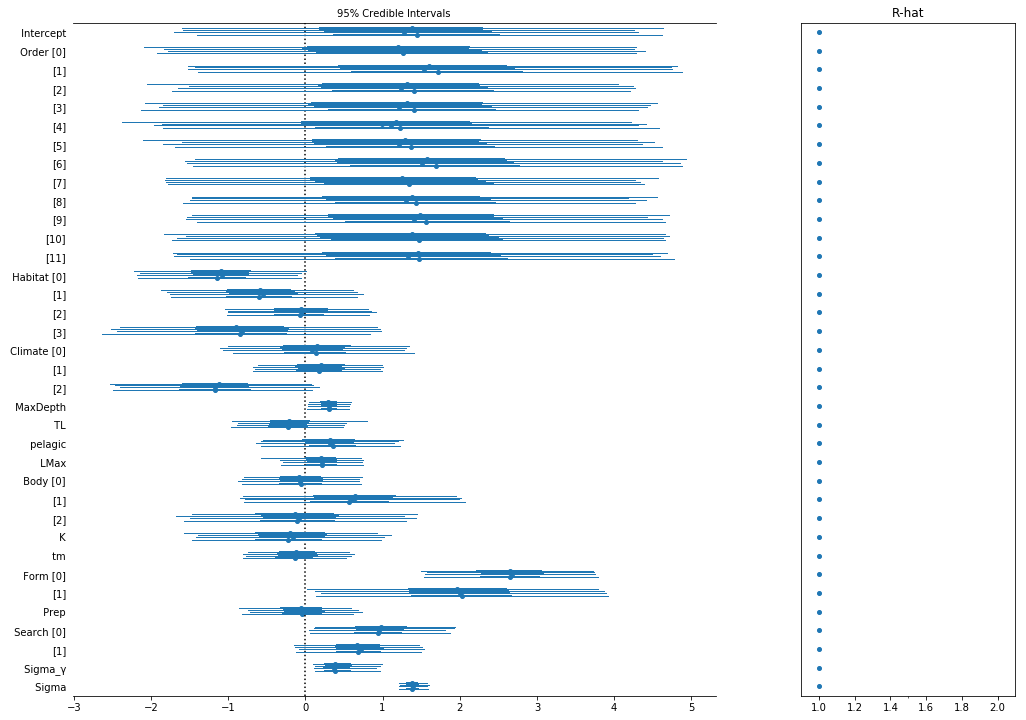

In [16]:
plt.figure(figsize=(17, 11))
pm.forestplot(trace)
plt.savefig('Figure_S3_'+nut+'.jpg',dpi=300);

In [17]:
# Export results 
out = pm.backends.tracetab.trace_to_dataframe(trace)
colnames = np.array(list(out.columns), dtype=object)
# Rename columns
colnames[match(grep('Habitat',list(colnames)),list(colnames))] = Habitat[1:]
colnames[match(grep('Climate',list(colnames)),list(colnames))] = Climate[1:]
colnames[match(grep('Body',list(colnames)),list(colnames))] = Body[1:]
colnames[match(grep('Form',list(colnames)),list(colnames))] = Form[1:]
colnames[match(grep('Prep',list(colnames)),list(colnames))] = Prep[1:]
colnames[match(grep('Search',list(colnames)),list(colnames))] = Search[1:]
# Rename
out.columns = list(colnames)

In [18]:
# Add baseline columns to dataframe
out['demersal'] = 0
out['temperate'] = 0
out['fusiform'] = 0
out['muscle'] = 0
out['wet'] = 0
out['WOS'] = 0

In [19]:
out.to_csv(nut+'_results.csv')

In [20]:
out.head()

,Intercept,Order__0,Order__1,Order__2,Order__3,Order__4,Order__5,Order__6,Order__7,Order__8,...,Expert,FAO,Sigma_γ,Sigma,demersal,temperate,fusiform,muscle,wet,WOS
0,0.199710,0.295739,0.257993,0.585181,0.184778,-0.194237,0.071503,0.538583,0.302045,0.125298,...,1.653662,1.425816,0.301528,1.526664,0,0,0,0,0,0
1,0.420172,0.419653,0.474583,0.276807,0.445963,0.689899,0.242844,0.348257,0.483907,0.707472,...,1.741774,1.447454,0.284500,1.508404,0,0,0,0,0,0
2,-0.295196,0.199747,-0.306953,0.253961,-0.056906,-0.217861,-0.280091,-0.113490,-0.433548,0.253857,...,1.392177,0.940360,0.280694,1.398228,0,0,0,0,0,0
3,2.806347,2.744608,2.803820,2.911754,2.649424,2.840678,2.629964,2.573367,2.607880,2.650606,...,0.032239,0.075054,0.193138,1.358910,0,0,0,0,0,0
4,0.634933,0.407673,0.603427,0.829185,0.947971,0.589990,0.793639,1.027518,0.474486,0.860914,...,0.970151,1.025387,0.208079,1.405613,0,0,0,0,0,0


### Model-checking

In [21]:
ppc = pm.sample_ppc(trace, model=Model_1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 20000/20000 [00:13<00:00, 1523.44it/s]


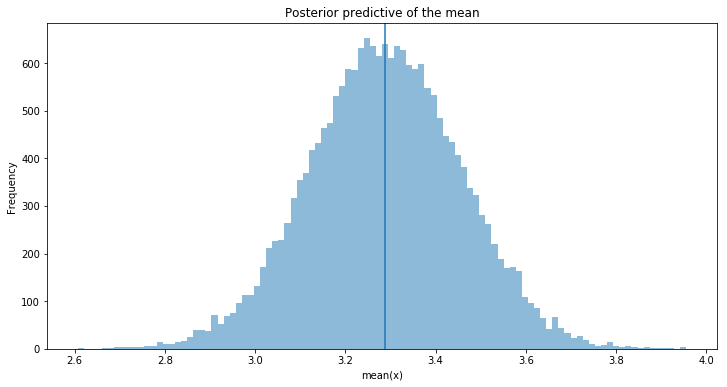

In [22]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in ppc['Yi']], bins=100, alpha=0.5)
ax.axvline(Y.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency')
plt.savefig('Figure_S4_'+nut+'.jpg',dpi=300);

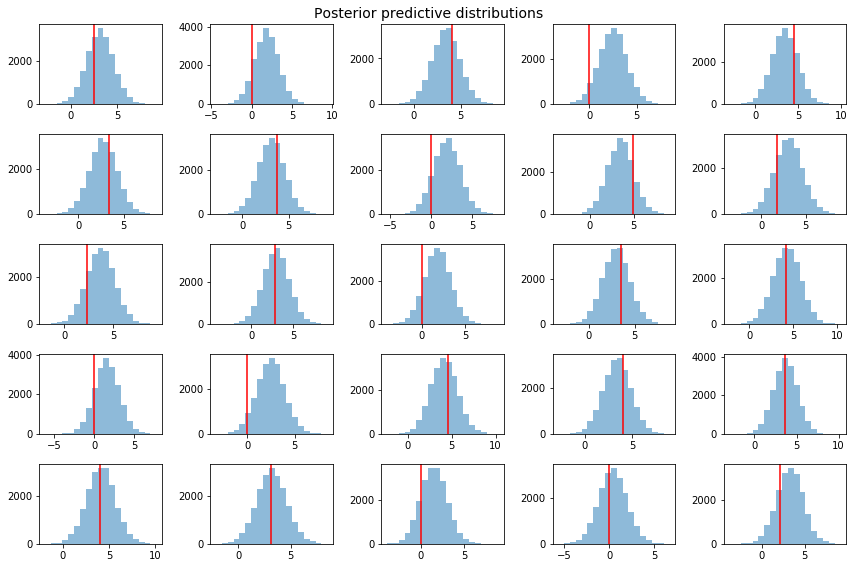

In [23]:
# Setup multipanel figure
nrows, ncols = 5, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8))
ax_ = axes.flatten()

# Transform ppc
PPC = ppc['Yi'].T
# Index random observations
indx = np.random.randint(0,len(PPC),size=nrows*ncols)

# Iterate over random samples from ppc
for i in range(nrows*ncols):
    ax1 = ax_[i]
    ax1.hist(PPC[indx[i]], bins=19, alpha=0.5)
    ax1.axvline(Y[indx[i]],c='red')

fig.tight_layout()
fig.suptitle('Posterior predictive distributions', fontsize=14)
fig.subplots_adjust(top=0.95)
plt.savefig('Figure_S5_'+nut+'.jpg',dpi=300);